In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Explore Database

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Precipitation Analysis

In [14]:
# Set figure size for all plots
plt.rcParams["figure.figsize"] = (9,6)

In [15]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

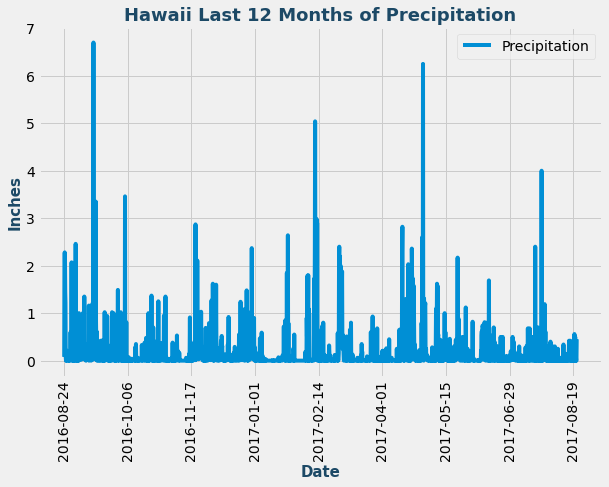

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores

year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(year_prcp, columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(['date'], ascending=True)

# Remove non values
prcp_df = prcp_df.dropna(how='any')

# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(rot=90)
plt.xlabel("Date", fontsize = 15, color = "#1c4966", fontweight="bold")
plt.ylabel("Inches", fontsize = 15, color = "#1c4966", fontweight="bold")
plt.title("Hawaii Last 12 Months of Precipitation", fontsize = 18, color = "#1c4966", fontweight="bold")
plt.legend(["Precipitation"], loc='upper right')
plt.show()


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_st = session.query(Measurement.station, func.count(Measurement.id)).\
            group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
active_st

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]
active_st_tobs = session.query(*sel)
active_st_tobs.all()

[(53.0, 87.0, 73.09795396419437)]

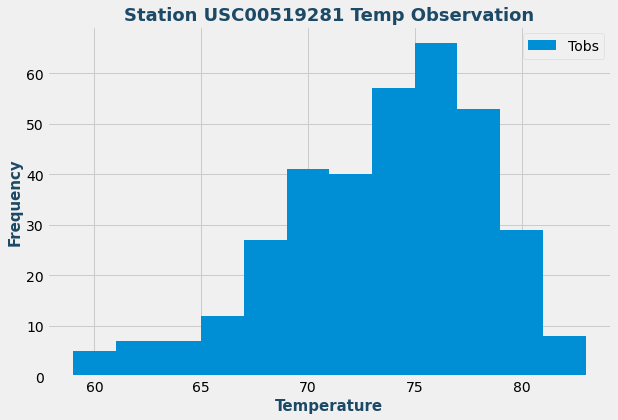

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.station, Measurement.tobs)\
    .filter(Measurement.date >= '2016-08-23')\
    .filter(Measurement.station == 'USC00519281')\
    .all()


# Pandas DataFrame
tobs_df = pd.DataFrame(tobs)

# Histogram
tobs_df.plot.hist(bins=12)
plt.xlabel("Temperature", fontsize = 15, color = "#1c4966", fontweight="bold")
plt.ylabel("Frequency", fontsize = 15, color = "#1c4966", fontweight="bold")
plt.title("Station USC00519281 Temp Observation", fontsize = 18, color = "#1c4966", fontweight="bold")
plt.legend(["Tobs"], loc='upper right')
plt.show()

# Close session

In [23]:
# Close Session
session.close()